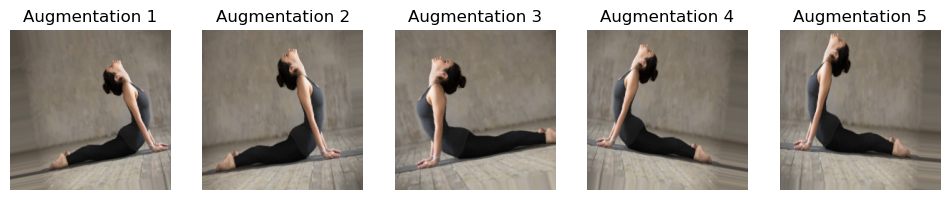

In [9]:
#data preproccessing
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt

# Constants
IMAGE_SIZE = (224, 224)

# Setup data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to preprocess a single image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)
    image = img_to_array(image) / 255.0
    return image

# Function to preprocess keypoints
def preprocess_keypoints(keypoints, image_shape):
    h, w = image_shape[:2]
    keypoints = np.array(keypoints) / [w, h]  # Normalize keypoints
    return keypoints.flatten()

# Function to augment data
def augment_data(image, keypoints):
    image = np.expand_dims(image, axis=0)
    augmented_images = []
    augmented_keypoints = []

    for _ in range(5):  # Generate 5 augmentations as an example
        augmented_image = next(datagen.flow(image, batch_size=1))[0]
        aug_keypoints = keypoints.copy()

        # Example augmentation for flipping keypoints if the image is flipped
        if datagen.horizontal_flip:
            aug_keypoints = keypoints.reshape(-1, 2)
            aug_keypoints[:, 0] = 1 - aug_keypoints[:, 0]  # Flip x-coordinates
            aug_keypoints = aug_keypoints.flatten()

        augmented_images.append(augmented_image)
        augmented_keypoints.append(aug_keypoints)

    return np.array(augmented_images), np.array(augmented_keypoints)

# Example usage
image_path = "C:/Users/Sudik/Desktop/istockphoto-924163406-612x612.jpg"
keypoints = [(50, 100), (100, 150), (150, 200)]  # Replace with actual key points

# Preprocess the image
preprocessed_image = preprocess_image(image_path)
preprocessed_keypoints = preprocess_keypoints(keypoints, preprocessed_image.shape)

# Generate augmented data
aug_images, aug_keypoints = augment_data(preprocessed_image, preprocessed_keypoints)

# Display results
plt.figure(figsize=(12, 6))
for i in range(5):  # Display first 5 augmentations
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(aug_images[i])
    plt.title(f"Augmentation {i + 1}")
    plt.axis('off')
plt.show()

In [10]:
!pip install tensorflow-hub

In [12]:
import tensorflow_hub as hub
print("TensorFlow Hub imported successfully!")

TensorFlow Hub imported successfully!


In [15]:
import tensorflow_hub as hub

Drawing keypoint at (156, 89) with confidence 0.4890141487121582
Drawing keypoint at (158, 92) with confidence 0.5480036735534668
Drawing keypoint at (158, 91) with confidence 0.662710428237915
Drawing keypoint at (153, 101) with confidence 0.6066779494285583
Drawing keypoint at (156, 98) with confidence 0.5582592487335205
Drawing keypoint at (140, 118) with confidence 0.7327284216880798
Drawing keypoint at (135, 90) with confidence 0.6328892111778259
Drawing keypoint at (144, 149) with confidence 0.7023522853851318
Drawing keypoint at (126, 58) with confidence 0.6772785186767578
Drawing keypoint at (153, 175) with confidence 0.6609565019607544
Drawing keypoint at (123, 34) with confidence 0.7809367775917053
Drawing keypoint at (96, 119) with confidence 0.6627087593078613
Drawing keypoint at (81, 107) with confidence 0.8199366331100464
Drawing keypoint at (123, 155) with confidence 0.6524029970169067
Drawing keypoint at (57, 147) with confidence 0.8186436891555786
Drawing keypoint at (

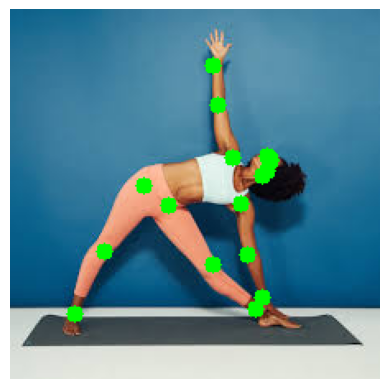

In [16]:
import tensorflow_hub as hub
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load MoveNet model from TensorFlow Hub
module_url = "https://tfhub.dev/google/movenet/singlepose/lightning/4"
movenet = hub.load(module_url)

def run_movenet(image_path):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    input_image = tf.image.resize_with_pad(tf.convert_to_tensor(image), 192, 192)
    input_image = tf.cast(input_image, dtype=tf.int32)
    input_image = tf.expand_dims(input_image, axis=0)  # Add batch dimension

    # Run the model using `signatures`
    outputs = movenet.signatures["serving_default"](input_image)
    keypoints = outputs['output_0'].numpy().reshape((17, 3))

    return image, keypoints

def draw_keypoints(image, keypoints, threshold=0.1):
    height, width, _ = image.shape
    for y, x, confidence in keypoints:
        if confidence > threshold:
            # Scale coordinates to original image size
            x = int(x * width)
            y = int(y * height)
            cv2.circle(image, (x, y), 5, (0, 255, 0), -1)
            print(f"Drawing keypoint at ({x}, {y}) with confidence {confidence}")
    return image

# Example usage
image_path = "C:/Users/Sudik/Desktop/images.jpg"  # Replace with your image path
original_image, keypoints = run_movenet(image_path)

# Draw the keypoints on the image
output_image = draw_keypoints(original_image, keypoints)

# Display the image with keypoints
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [19]:
#loading movenet model
#importing singlepose from movenet
#uploading own dataset for collecting keypoints using movenet model
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub

# Load MoveNet model and get the default signature function
movenet_model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
movenet = movenet_model.signatures['serving_default']

# Preprocess function to prepare images for MoveNet
def preprocess_image(image):
    image = tf.image.resize_with_pad(tf.expand_dims(image, axis=0), 192, 192)
    image = tf.cast(image, dtype=tf.int32)  # MoveNet requires int32 images
    return image

# Function to extract keypoints
def extract_keypoints(image):
    processed_image = preprocess_image(image)
    keypoints_with_scores = movenet(processed_image)
    keypoints = keypoints_with_scores['output_0']
    return np.squeeze(keypoints)

# Load images from the dataset directory
dataset_path = "C:/Users/Sudik/Desktop/Sudiksha/btech project/data"  # Replace with your dataset path
image_size = (192, 192)
batch_size = 32

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=image_size,
    batch_size=batch_size
)

# Process each batch of images to extract keypoints
all_keypoints_data = []
for batch, _ in dataset:
    for image in batch:
        keypoints = extract_keypoints(image)
        all_keypoints_data.append(keypoints)

Found 32 files belonging to 3 classes.


In [31]:
#data preprocessing -> flattening keypoints and associating them with labels
import numpy as np

# Function to preprocess the keypoints data
def preprocess_keypoints_data(keypoints_data, labels):
    processed_data = []
    for keypoints, label in zip(keypoints_data, labels):
        # Flatten the keypoints array (shape: 17 keypoints * 3 [x, y, confidence] = 51 values)
        flattened_keypoints = keypoints.flatten()
        # Append flattened keypoints and label as a tuple
        processed_data.append((flattened_keypoints, label))
    return processed_data

# Example extracted keypoints (replace this with your actual keypoints)
# Assume we have 3 images and their corresponding keypoints
all_keypoints_data = [
    np.random.rand(17, 3),  # Keypoints for image 1
    np.random.rand(17, 3),  # Keypoints for image 2
    np.random.rand(17, 3)   # Keypoints for image 3
]

# Define corresponding labels for each keypoints array
# Make sure this list has the same length as all_keypoints_data
labels = ['downdog', 'plank', 'warrior']  # Adjust based on your dataset

# Check that lengths match
if len(all_keypoints_data) != len(labels):
    raise ValueError("The length of all_keypoints_data must match the length of labels.")

# Call the preprocessing function with your data
processed_data = preprocess_keypoints_data(all_keypoints_data, labels)

# Convert to numpy arrays for easy handling with machine learning frameworks
X = np.array([item[0] for item in processed_data])  # Feature matrix
y = np.array([item[1] for item in processed_data])  # Labels

# Now X contains the flattened keypoints for each sample, and y contains corresponding labels
print("Shape of X:", X.shape)  # Should be (num_samples, 51)
print("Shape of y:", y.shape)  # Should be (num_samples,)

Shape of X: (3, 51)
Shape of y: (3,)


In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_hub as hub

# Load the original MoveNet model
def load_movenet_model():
    model = hub.load("https://www.kaggle.com/models/google/movenet/TensorFlow2/singlepose-lightning/4")
    movenet = model.signatures['serving_default']
    return model

# Define a function to run the MoveNet model
@tf.function
def run_movenet_model(model, input_tensor):
    return model(input_tensor)

# Build the fine-tuning model
def build_fine_tuning_model(movenet_model, input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)  # Input layer for images
    x = layers.Rescaling(1./255)(inputs)  # Rescale pixel values to [0, 1]

    # Call the MoveNet model to get keypoints and scores
    keypoints_with_scores = run_movenet_model(movenet_model, x)
    keypoints = keypoints_with_scores['output_0']  # Access the appropriate output key

    # Flatten the keypoints output
    x = layers.Flatten()(keypoints)  # Flatten the keypoints output for dense layers
    x = layers.Dense(128, activation='relu')(x)  # Hidden dense layer
    x = layers.Dropout(0.5)(x)  # Dropout layer for regularization
    outputs = layers.Dense(num_classes, activation='softmax')(x)  # Output layer

    # Create the final model
    fine_tuning_model = models.Model(inputs, outputs)

    return fine_tuning_model

# Load the MoveNet model once
movenet_model = load_movenet_model()

# Specify input shape and number of classes
input_shape = (256, 256, 3)  # Adjust as necessary
num_classes = len(set(labels))  # Use the number of unique labels

# Create the model
fine_tuning_model = build_fine_tuning_model(movenet_model, input_shape, num_classes)

# Compile the model
fine_tuning_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
fine_tuning_model.summary()

ValueError: A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

In [35]:
print(tf.__version__)

2.18.0
